In [1]:
import torch
import pandas as pd
import numpy as np
import lovely_tensors as lt
from tqdm.auto import tqdm
import torch.nn.functional as F
import sys

sys.path.append('/app')
lt.monkey_patch()

## Prepare data

In [8]:
zsd_tensor = torch.nan_to_num(torch.load('/app/data/zsd_tensor.pt'), nan=0.0)
zsd_tensor

tensor[276, 1, 337, 385] f64 n=35809620 x∈[0., 39.371] μ=9.118 σ=7.594

In [9]:
x = zsd_tensor[:-1]
y_gt = zsd_tensor[-1]
x, y_gt

(tensor[275, 1, 337, 385] f64 n=35679875 x∈[0., 39.371] μ=9.115 σ=7.592,
 tensor[1, 337, 385] f64 n=129745 x∈[0., 34.016] μ=9.905 σ=8.071)

### metrics

In [41]:
min_zsd = x.min().item()
max_zsd = x.max().item()
min_zsd, max_zsd

(0.0, 39.371402740478516)

In [42]:
def calculate_accuracy(y_gt, y_pred, meters=3, max_zsd=39):
    gt_labels = torch.zeros_like(y_gt)
    pred_labels = torch.zeros_like(y_pred)
    labels = (torch.arange(max_zsd//meters) * meters)
    
    # label data
    for i, label in enumerate(labels):
        if label == labels.max():
            gt_labels[(y_gt > label)] = i 
            pred_labels[(y_pred > label)] = i
        else:
            gt_labels[(y_gt > label) & (y_gt < label+meters)] = i
            pred_labels[(y_pred > label) & (y_pred < label+meters)] = i
    # Calculate metrics
    correct = torch.eq(pred_labels, gt_labels)
    accuracy = torch.mean(correct.float())
    
    return accuracy

## Prepare AR baseline model

In [10]:
from statsmodels.tsa.ar_model import AutoReg

In [30]:
H, W = x.shape[-2:]
H, W

(337, 385)

In [53]:
def run_AR_baseline(x, y_gt, lags=8):
    y_pred = torch.zeros_like(y_gt)
    for x_i in tqdm(range(W)):
        for y_i in range(H):
            ar_model = AutoReg(x[:,0,y_i,x_i].numpy(), lags=lags).fit()
            y_pred[:, y_i, x_i] = ar_model.predict(x.shape[0], x.shape[0]+1, dynamic=False)[-1]
            
    return y_pred

In [38]:
y_pred = run_AR_baseline(x, y_gt, lags=8)

  0%|          | 0/385 [00:00<?, ?it/s]

In [58]:
y_pred30 = run_AR_baseline(x, y_gt, lags=30)

  0%|          | 0/385 [00:00<?, ?it/s]

In [54]:
y_pred52 = run_AR_baseline(x, y_gt, lags=30)

  0%|          | 0/385 [00:00<?, ?it/s]

In [44]:
meters_eval = [2, 3, 4, 5]
for meters in meters_eval:
    acc = calculate_accuracy(y_gt, y_pred, meters=meters).item()
    print(f'Accuracy for {meters} m. range:{acc:.3f}')

Accuracy for 2 m. range:0.488
Accuracy for 3 m. range:0.567
Accuracy for 4 m. range:0.637
Accuracy for 5 m. range:0.667


In [39]:
y_pred

tensor[1, 337, 385] f64 n=129745 x∈[0., 30.900] μ=10.637 σ=8.102

In [13]:
ar_model = AutoReg(x[:,0,0,0].numpy(), lags=8).fit()

In [29]:
ar_model.predict(x.shape[0], x.shape[0]+1, dynamic=False)[-1]

24.670564362179498

In [17]:
x[-8:,0,0,0]

tensor[8] f64 x∈[21.669, 32.160] μ=27.197 σ=4.197 [32.160, 31.520, 29.956, 29.925, 22.159, 21.669, 24.833, 25.354]

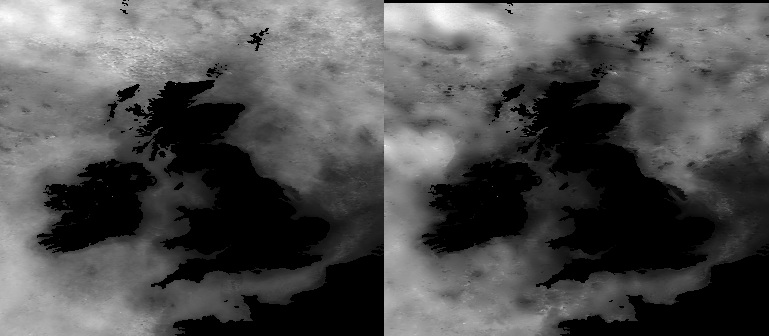

In [46]:
torch.cat([y_pred.expand((3, 337,385))/y_pred.max(), y_gt.expand((3, 337,385))/y_gt.max()], dim=-1).rgb

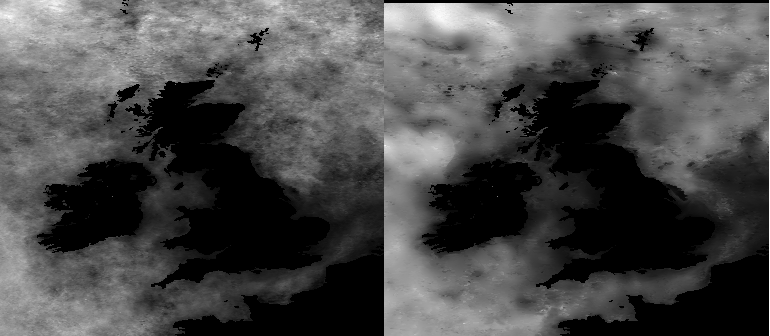

In [55]:
torch.cat([y_pred52.expand((3, 337,385))/y_pred52.max(), y_gt.expand((3, 337,385))/y_gt.max()], dim=-1).rgb

In [59]:
print(f'RMSE from prev 8 days:{F.mse_loss(y_gt, y_pred).sqrt().item()}')
print(f'RMSE from prev 30 days:{F.mse_loss(y_gt, y_pred30).sqrt().item()}')
print(f'RMSE from prev 52 days:{F.mse_loss(y_gt, y_pred52).sqrt().item()}')

RMSE from prev 8 days:3.575846322391082
RMSE from prev 30 days:3.7314336502478125
RMSE from prev 52 days:4.017383614889604


In [62]:
from tools.metrics import eval_metrics

In [63]:
eval_metrics(y_gt, y_pred)

Accuracy for 2 m. range:0.488
Accuracy for 3 m. range:0.567
Accuracy for 4 m. range:0.637
Accuracy for 5 m. range:0.667
MSE for predicted frame: 3.576


In [64]:
eval_metrics(y_gt, y_pred30)

Accuracy for 2 m. range:0.463
Accuracy for 3 m. range:0.542
Accuracy for 4 m. range:0.608
Accuracy for 5 m. range:0.643
MSE for predicted frame: 3.731


In [65]:
eval_metrics(y_gt, y_pred52)

Accuracy for 2 m. range:0.448
Accuracy for 3 m. range:0.522
Accuracy for 4 m. range:0.584
Accuracy for 5 m. range:0.623
MSE for predicted frame: 4.017
